In [15]:
import pandas as pd
import numpy as np
from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import dowhy
from dowhy import CausalModel
import networkx as nx
import dowhy.gcm as gcm
import dowhy.api
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

In [56]:
column_names = ['CkgAcct', 'Duration', 'CreditHistory', 'Purpose', 'CreditAmt', 'Savings', 'EmploymentTime',
               'PctIncome', 'PersStatus', 'OtherDebts', 'ResidenceSince', 'Property',
               'AgeYrs', 'OtherLoan', 'Housing', 'NumCredits', 'Job', 'FamSize', 'Telephone',
               'Foriegn', 'LoanGood']
df = pd.read_table('C:/Users/cptas/german.data.txt', names=column_names, sep=' ')
df

,CkgAcct,Duration,CreditHistory,Purpose,CreditAmt,Savings,EmploymentTime,PctIncome,PersStatus,OtherDebts,...,Property,AgeYrs,OtherLoan,Housing,NumCredits,Job,FamSize,Telephone,Foriegn,LoanGood
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


In [57]:
df2 = pd.read_csv('C:/Users/cptas/german_credit_data.csv',  index_col=0)
df2['Loan'] = df['LoanGood']
df2

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Loan
0,67,male,2,own,NaN,little,1169,6,radio/TV,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,2
2,49,male,1,own,little,NaN,2096,12,education,1
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,2
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,1
996,40,male,3,own,little,little,3857,30,car,1
997,38,male,2,own,little,NaN,804,12,radio/TV,1
998,23,male,2,free,little,little,1845,45,radio/TV,2


In [24]:
total= df2.isnull().sum().sort_values(ascending=False)
percent= (df2.isnull().sum()/df2.isnull().count()).sort_values(ascending=False)*100
missing_data= pd.concat([total, percent],axis=1, keys=["Total", "Percent"])
missing_data.head(15)

,Total,Percent
Checking account,394,39.4
Saving accounts,183,18.3
Age,0,0.0
Sex,0,0.0
Job,0,0.0
Housing,0,0.0
Credit amount,0,0.0
Duration,0,0.0
Purpose,0,0.0
Loan,0,0.0


In [58]:
df = df2[['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Credit amount', 'Duration', 'Purpose', 'Loan']]

In [59]:
df['Sex'] = np.where((df.Sex == 'male'), 1, 0)
df['Housing'] = np.where((df.Housing == 'own'), 1, 0)
df['Job'] = np.where((df.Job == 2), 1, 0)
df['Loan'] = np.where((df.Loan == 1), 1, 0)

C:\Users\cptas\AppData\Local\Temp\ipykernel_27128\2088349795.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sex'] = np.where((df.Sex == 'male'), 1, 0)
C:\Users\cptas\AppData\Local\Temp\ipykernel_27128\2088349795.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Housing'] = np.where((df.Housing == 'own'), 1, 0)
C:\Users\cptas\AppData\Local\Temp\ipykernel_27128\2088349795.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [48]:
df_encoded = pd.get_dummies(df, columns=['Saving accounts', 'Purpose'])
df_encoded

,Age,Sex,Job,Housing,Credit amount,Duration,Loan,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,1,2,1,1169,6,1,0,0,0,0,0,0,0,0,0,1,0,0
1,22,0,2,1,5951,48,0,1,0,0,0,0,0,0,0,0,1,0,0
2,49,1,1,1,2096,12,1,1,0,0,0,0,0,0,1,0,0,0,0
3,45,1,2,0,7882,42,1,1,0,0,0,0,0,0,0,1,0,0,0
4,53,1,2,0,4870,24,0,1,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,31,0,1,1,1736,12,1,1,0,0,0,0,0,0,0,1,0,0,0
996,40,1,3,1,3857,30,1,1,0,0,0,0,1,0,0,0,0,0,0
997,38,1,2,1,804,12,1,1,0,0,0,0,0,0,0,0,1,0,0
998,23,1,2,0,1845,45,0,1,0,0,0,0,0,0,0,0,1,0,0


In [62]:
#Logistic Regression 
X = df_encoded.drop(['Loan'], axis=1)
y = df_encoded['Loan']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit a logistic regression model
lr_model = LogisticRegression(max_iter=50)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)
score = lr_model.score(X_test, y_test)
print(f"Accuracy: {score}")

# Compute fairness metrics
dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test['Sex'])
eod_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=X_test['Sex'])

# Print fairness metrics
print("Demographic Parity Difference: ", dp_diff)
print("Equalized Odds Difference: ", eod_diff)

Accuracy: 0.6933333333333334
Demographic Parity Difference:  0.1348627787307033
Equalized Odds Difference:  0.2686318131256953


c:\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c:\.conda\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Warning: pos attribute for edge (Sex,Loan) doesn't have 3n+1 points

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


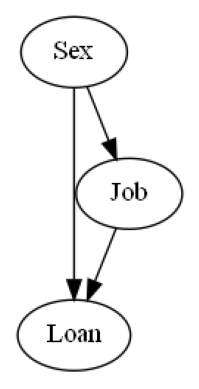

Fitting causal mechanism of node Job: 100%|██████████| 3/3 [00:00<00:00, 27.64it/s]


In [63]:
#SCM
dataset = df_encoded.copy()
causal_model = gcm.InvertibleStructuralCausalModel(nx.DiGraph([('Sex', 'Loan'), ('Sex', 'Job'), ('Job', 'Loan')]))
gcm.auto.assign_causal_mechanisms(causal_model, dataset)

gcm.util.plot(causal_model.graph)

gcm.fit(causal_model, dataset)

In [64]:
cf1 = gcm.draw_samples(causal_model, num_samples=1000)
cf1.head()

,Sex,Job,Loan
0,0,1.900704,0.925199
1,0,1.000000,0.949353
2,1,3.099296,0.997337
3,0,1.900704,0.925199
4,1,2.000000,1.026818


In [65]:
df_encoded[['Sex', 'Job', 'Loan']] = cf1[['Sex', 'Job', 'Loan']]
df_encoded['Loan'] = np.where((df_encoded.Loan > 0.5), 1, 0)
df_encoded

,Age,Sex,Job,Housing,Credit amount,Duration,Loan,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,0,1.900704,1,1169,6,0.925199,0,0,0,0,0,0,0,0,0,1,0,0
1,22,0,1.000000,1,5951,48,0.949353,1,0,0,0,0,0,0,0,0,1,0,0
2,49,1,3.099296,1,2096,12,0.997337,1,0,0,0,0,0,0,1,0,0,0,0
3,45,0,1.900704,0,7882,42,0.925199,1,0,0,0,0,0,0,0,1,0,0,0
4,53,1,2.000000,0,4870,24,1.026818,1,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,31,0,1.900704,1,1736,12,1.002663,1,0,0,0,0,0,0,0,1,0,0,0
996,40,1,3.000000,1,3857,30,-0.053635,1,0,0,0,0,1,0,0,0,0,0,0
997,38,0,2.000000,1,804,12,0.868900,1,0,0,0,0,0,0,0,0,1,0,0
998,23,1,2.000000,0,1845,45,0.050647,1,0,0,0,0,0,0,0,0,1,0,0


In [68]:
#Logistic Regression with SCM
X = df_encoded.drop(['Loan'], axis=1)
y = df_encoded['Loan']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit a logistic regression model
lr_model = LogisticRegression(max_iter=50)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)
score = lr_model.score(X_test, y_test)
print(f"Accuracy: {score}")

# Compute fairness metrics
dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test['Sex'])
eod_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=X_test['Sex'])

# Print fairness metrics
print("Demographic Parity Difference: ", dp_diff)
print("Equalized Odds Difference: ", eod_diff)

Accuracy: 0.72
Demographic Parity Difference:  0.0
Equalized Odds Difference:  0.0


In [74]:
df = df2[['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Credit amount', 'Duration', 'Purpose', 'Loan']]
df['Sex'] = np.where((df.Sex == 'male'), 1, 0)
df['Housing'] = np.where((df.Housing == 'own'), 1, 0)
df['Job'] = np.where((df.Job == 2), 1, 0)
df['Loan'] = np.where((df.Loan == 1), 1, 0)
df_encoded = pd.get_dummies(df, columns=['Saving accounts', 'Purpose'])

C:\Users\cptas\AppData\Local\Temp\ipykernel_27128\2855055580.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sex'] = np.where((df.Sex == 'male'), 1, 0)
C:\Users\cptas\AppData\Local\Temp\ipykernel_27128\2855055580.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Housing'] = np.where((df.Housing == 'own'), 1, 0)
C:\Users\cptas\AppData\Local\Temp\ipykernel_27128\2855055580.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

,Age,Sex,Job,Housing,Credit amount,Duration,Loan,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,1,1,1,1169,6,1,0,0,0,0,0,0,0,0,0,1,0,0
1,22,0,1,1,5951,48,0,1,0,0,0,0,0,0,0,0,1,0,0
2,49,1,0,1,2096,12,1,1,0,0,0,0,0,0,1,0,0,0,0
3,45,1,1,0,7882,42,1,1,0,0,0,0,0,0,0,1,0,0,0
4,53,1,1,0,4870,24,0,1,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,31,0,0,1,1736,12,1,1,0,0,0,0,0,0,0,1,0,0,0
996,40,1,0,1,3857,30,1,1,0,0,0,0,1,0,0,0,0,0,0
997,38,1,1,1,804,12,1,1,0,0,0,0,0,0,0,0,1,0,0
998,23,1,1,0,1845,45,0,1,0,0,0,0,0,0,0,0,1,0,0


In [77]:
#Random Forest
X = df_encoded.drop(['Loan'], axis=1)
y = df_encoded['Loan']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Train and test the Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
rfc_predictions = rfc.predict(X_test)
rfc_score = rfc.score(X_test, y_test)
print(f"Accuracy: {rfc_score}")

# Train and test the XGBoost Classifier
xgbc = XGBClassifier(random_state=42)
xgbc.fit(X_train, y_train)
xgbc_predictions = xgbc.predict(X_test)
xgbc_score = xgbc.score(X_test, y_test)
print(f"Accuracy: {xgbc_score}")


# Compute fairness metrics
rfc_dp_diff = demographic_parity_difference(y_test, rfc_predictions, sensitive_features=X_test['Sex'])
rfc_eod_diff = equalized_odds_difference(y_test, rfc_predictions, sensitive_features=X_test['Sex'])

# Print fairness metrics
print("Demographic Parity Difference: ", rfc_dp_diff)
print("Equalized Odds Difference: ", rfc_eod_diff)

# Compute fairness metrics
xgbc_dp_diff = demographic_parity_difference(y_test, xgbc_predictions, sensitive_features=X_test['Sex'])
xgbc_eod_diff = equalized_odds_difference(y_test, xgbc_predictions, sensitive_features=X_test['Sex'])

# Print fairness metrics
print("Demographic Parity Difference: ", xgbc_dp_diff)
print("Equalized Odds Difference: ", xgbc_eod_diff)

Accuracy: 0.7033333333333334
Accuracy: 0.6833333333333333
Demographic Parity Difference:  0.03366209262435671
Equalized Odds Difference:  0.04892655367231635
Demographic Parity Difference:  0.14172384219554024
Equalized Odds Difference:  0.2408231368186874


In [79]:
dataset = df_encoded.copy()
causal_model3 = gcm.InvertibleStructuralCausalModel(nx.DiGraph([('Sex', 'Loan'), ('Job', 'Loan'), ('Sex', 'Job')]))
gcm.auto.assign_causal_mechanisms(causal_model3, dataset)

gcm.fit(causal_model3, dataset)

Fitting causal mechanism of node Job: 100%|██████████| 3/3 [00:00<00:00, 33.51it/s]


In [80]:
cf2 = gcm.draw_samples(causal_model3, num_samples=1000)
df_encoded[['Sex', 'Job', 'Loan']] = cf2[['Sex', 'Job', 'Loan']]

In [82]:
#XGBoost
df_encoded['Loan'] = np.where((df_encoded.Loan > 0.5), 1, 0)
X = df_encoded.drop(['Loan'], axis=1)
y = df_encoded['Loan']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Train and test the Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
rfc_predictions = rfc.predict(X_test)
rfc_score = rfc.score(X_test, y_test)
print(f"Accuracy: {rfc_score}")

# Train and test the XGBoost Classifier
xgbc = XGBClassifier(random_state=42)
xgbc.fit(X_train, y_train)
xgbc_predictions = xgbc.predict(X_test)
xgbc_score = xgbc.score(X_test, y_test)
print(f"Accuracy: {xgbc_score}")


# Compute fairness metrics
rfc_dp_diff = demographic_parity_difference(y_test, rfc_predictions, sensitive_features=X_test['Sex'])
rfc_eod_diff = equalized_odds_difference(y_test, rfc_predictions, sensitive_features=X_test['Sex'])

# Print fairness metrics
print("Demographic Parity Difference: ", rfc_dp_diff)
print("Equalized Odds Difference: ", rfc_eod_diff)

# Compute fairness metrics
xgbc_dp_diff = demographic_parity_difference(y_test, xgbc_predictions, sensitive_features=X_test['Sex'])
xgbc_eod_diff = equalized_odds_difference(y_test, xgbc_predictions, sensitive_features=X_test['Sex'])

# Print fairness metrics
print("Demographic Parity Difference: ", xgbc_dp_diff)
print("Equalized Odds Difference: ", xgbc_eod_diff)

Accuracy: 0.6433333333333333
Accuracy: 0.6166666666666667
Demographic Parity Difference:  0.00338325289815411
Equalized Odds Difference:  0.014938298332972555
Demographic Parity Difference:  0.03293696203791241
Equalized Odds Difference:  0.08216064083134877
